In [ ]:
import tensorflow as tf
from GAN import GAN

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Session start
epoch :  0 , gen_cost :  -0.0011391634 , dis_cost :  -0.014764475


C:\Users\JAEKYU\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


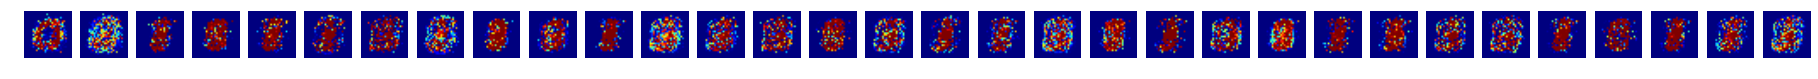

In [ ]:
with tf.Session() as sess:
    GAN_object = GAN(sess, batch_size = 32)
    GAN_object.training()